In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import transbigdata as tbd

In [2]:
from matplotlib import rc


rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 26})

In [3]:
jobs = gpd.read_file('dbs/jobs.shp') # 4326
jobs = jobs.to_crs(4326)
jobs.rename(columns={'car_owners': 'car_ownership'}, inplace=True)
print(len(jobs))
jobs.head(2)

3363


,zone,grid_size,income_q1,income_q2,income_q3,income_q4,income_med,pop_income,birth_se,birth_nord,...,car_ownership,access,gain_ratio,nativity,q1_share,q4_share,q23_share,ICE_income,Income,geometry
0,3230006403750,250,31.0,30.0,26.0,24.0,227829.0,111.0,133.0,7.0,...,0.281923,35333.313673,0.471895,foreign-born,0.279279,0.216216,0.504505,-0.084337,non-segregated,"POLYGON ((12.02641 57.74090, 12.02623 57.74314..."
1,3210006409000,250,3.0,6.0,8.0,6.0,264116.0,23.0,48.0,0.0,...,0.456395,33727.233443,3.437490,foreign-born,0.130435,0.260870,0.608696,0.187500,non-segregated,"POLYGON ((11.98895 57.78720, 11.98876 57.78944..."


In [83]:
print('number of non-pop regions:', np.sum(jobs['pop']==0))
print('segregated towards native-born:', np.sum(jobs['adj_ICE'] >= 0.2))
print('segregated towards foreign-born:', np.sum(jobs['adj_ICE'] <= -0.2))
print('non-segregated:', np.sum((jobs['adj_ICE'] > -0.2) & (jobs['adj_ICE'] < 0.2)))

number of non-pop regions: 0
segregated towards native-born: 1413
segregated towards foreign-born: 865
non-segregated: 1085


In [84]:
jobs = jobs[jobs['pop'] != 0]

jobs.loc[jobs['adj_ICE'] <= -0.2, 'nativity'] = 'foreign-born'
jobs.loc[jobs['adj_ICE'] >= 0.2, 'nativity'] = 'native-born'
jobs.loc[(jobs['adj_ICE'] > -0.2) & (jobs['adj_ICE'] < 0.2), 'nativity'] = 'non-segregated'

jobs.head(2)

,zone,grid_size,income_q1,income_q2,income_q3,income_q4,income_med,pop_income,birth_se,birth_nord,...,car_ownership,access,gain_ratio,nativity,q1_share,q4_share,q23_share,ICE_income,Income,geometry
0,3230006403750,250,31.0,30.0,26.0,24.0,227829.0,111.0,133.0,7.0,...,0.281923,35333.313673,0.471895,foreign-born,0.279279,0.216216,0.504505,-0.084337,non-segregated,"POLYGON ((12.02641 57.74090, 12.02623 57.74314..."
1,3210006409000,250,3.0,6.0,8.0,6.0,264116.0,23.0,48.0,0.0,...,0.456395,33727.233443,3.437490,foreign-born,0.130435,0.260870,0.608696,0.187500,non-segregated,"POLYGON ((11.98895 57.78720, 11.98876 57.78944..."


In [85]:
jobs['Income'] = jobs['Income'].replace({
    'less wealthy': 'low-income',
    'wealthy': 'high-income',
    'non-segregated': 'moderate'
})


# Initial visualization

In [86]:
min_lon = 11.65
min_lat = 57.53
max_lon = 12.30
max_lat = 57.88
bounding_box = (min_lon, min_lat, max_lon, max_lat)


In [ ]:
jobs = jobs.to_crs(4326)

fig = plt.figure(1, (18, 16), dpi=500)
ax = plt.subplot(111)
plt.sca(ax)
tbd.plot_map(plt, bounds=bounding_box, zoom=13)

jobs.plot(column='nativity', cmap='viridis_r', ax=ax, legend=True, alpha=0.7)

plt.title('nativity', fontsize = 28)
plt.xlabel('Longitude', fontsize = 24)
plt.ylabel('Latitude', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
jobs = jobs.to_crs(4326)

fig = plt.figure(1, (18, 16), dpi=500)
ax = plt.subplot(111)
plt.sca(ax)
tbd.plot_map(plt, bounds=bounding_box, zoom=13)

jobs.plot(column='Income', cmap='viridis', ax=ax, legend=True, alpha=0.7)

plt.title('Income', fontsize = 28)
plt.xlabel('Longitude', fontsize = 24)
plt.ylabel('Latitude', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [ ]:
fig = plt.figure(1, (18, 16), dpi=500)
ax = plt.subplot(111)
plt.sca(ax)
tbd.plot_map(plt, bounds=bounding_box, zoom=13)

jobs.plot(column='car_ownership', cmap='viridis', ax=ax, legend=True, alpha=0.7)

plt.title('car ownership', fontsize = 28)
plt.xlabel('Longitude', fontsize = 24)
plt.ylabel('Latitude', fontsize = 24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [88]:
temp = jobs[jobs['pop_income'] != 0]

jobs = temp
del temp

jobs['q1_share'] = jobs['income_q1'] / jobs['pop_income']
jobs['q4_share'] = jobs['income_q4'] / jobs['pop_income']
jobs['q23_share'] = 1-jobs['q1_share']-jobs['q4_share']
jobs['ai'] = jobs['q4_share'] / 0.25
jobs['bi'] = jobs['q1_share'] / 0.25
jobs['oi'] = jobs['q23_share'] / (1 - 0.25 - 0.25)
jobs['ICE_income'] = (jobs['ai'] - jobs['bi']) / (jobs['ai'] + jobs['bi'] + jobs['oi'])
jobs[['zone', 'q1_share', 'q4_share', 'ICE_income']].head()

,zone,q1_share,q4_share,ICE_income
0,3230006403750,0.279279,0.216216,-0.084337
1,3210006409000,0.130435,0.260870,0.187500
2,3312506409500,0.000000,0.700000,0.823529
3,3230006389500,0.086207,0.310345,0.320988
4,3175006405250,0.068493,0.356164,0.403846


In [89]:
jobs = jobs.drop(columns=['ai', 'bi', 'oi'])

jobs.loc[jobs['ICE_income'] <= -0.3, 'Income'] = 'less wealthy'
jobs.loc[jobs['ICE_income'] >= 0.3, 'Income'] = 'wealthy'
jobs.loc[(jobs['ICE_income'] > -0.3) & (jobs['ICE_income'] < 0.3), 'Income'] = 'non-segregated'
jobs.head()

,zone,grid_size,income_q1,income_q2,income_q3,income_q4,income_med,pop_income,birth_se,birth_nord,...,car_ownership,access,gain_ratio,nativity,q1_share,q4_share,q23_share,ICE_income,Income,geometry
0,3230006403750,250,31.0,30.0,26.0,24.0,227829.0,111.0,133.0,7.0,...,0.281923,35333.313673,0.471895,foreign-born,0.279279,0.216216,0.504505,-0.084337,non-segregated,"POLYGON ((12.02641 57.74090, 12.02623 57.74314..."
1,3210006409000,250,3.0,6.0,8.0,6.0,264116.0,23.0,48.0,0.0,...,0.456395,33727.233443,3.437490,foreign-born,0.130435,0.260870,0.608696,0.187500,non-segregated,"POLYGON ((11.98895 57.78720, 11.98876 57.78944..."
2,3312506409500,250,0.0,0.0,3.0,7.0,409891.0,10.0,26.0,0.0,...,0.539089,90.297014,0.261715,native-born,0.000000,0.700000,0.300000,0.823529,wealthy,"POLYGON ((12.16077 57.79566, 12.16059 57.79791..."
3,3230006389500,250,5.0,16.0,19.0,18.0,290400.0,58.0,141.0,0.0,...,0.490665,686.199069,0.823368,native-born,0.086207,0.310345,0.603448,0.320988,wealthy,"POLYGON ((12.03687 57.61307, 12.03669 57.61532..."
4,3175006405250,250,5.0,21.0,21.0,26.0,304134.0,73.0,164.0,6.0,...,0.456250,10043.198093,1.117651,non-segregated,0.068493,0.356164,0.575342,0.403846,wealthy,"POLYGON ((11.93302 57.75216, 11.93283 57.75440..."


In [73]:
jobs.to_file('dbs/jobs.shp')

/var/folders/xj/chyyxpd17_q6b_qhc97rxl2r0000gn/T/ipykernel_78694/2763561039.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  jobs.to_file('dbs/jobs.shp')


# actual data

In [90]:
actual_data = pd.read_csv('gothenburg2022_new.csv')
gdf_actual_data = gpd.GeoDataFrame(actual_data, 
                                   geometry=gpd.points_from_xy(actual_data['o_lng'], actual_data['o_lat']),
                                   crs='EPSG:4326'
                                  )


In [91]:
joined_data = gpd.sjoin(jobs, gdf_actual_data, predicate='intersects')
joined_data['count']=1

counts = joined_data.groupby(['zone']).agg({'count': 'sum'})
counts = counts[counts['count'] >=5] # select ESS-availability

available_jobs = jobs[jobs['zone'].isin(counts.index)]
print(len(available_jobs))
available_jobs.head()


533


,zone,grid_size,income_q1,income_q2,income_q3,income_q4,income_med,pop_income,birth_se,birth_nord,...,car_ownership,access,gain_ratio,nativity,q1_share,q4_share,q23_share,ICE_income,Income,geometry
7,3192506398000,250,51.0,54.0,69.0,70.0,271748.0,244.0,347.0,4.0,...,0.238986,37733.368642,0.288757,non-segregated,0.209016,0.286885,0.504098,0.104110,non-segregated,"POLYGON ((11.96783 57.68783, 11.96764 57.69007..."
17,3227506401000,250,109.0,119.0,165.0,111.0,264943.0,504.0,654.0,23.0,...,0.281981,40206.074215,0.631524,non-segregated,0.216270,0.220238,0.563492,0.005525,non-segregated,"POLYGON ((12.02425 57.71613, 12.02406 57.71838..."
29,3200006398500,250,34.0,29.0,19.0,46.0,262426.0,128.0,194.0,6.0,...,0.352585,26912.278305,0.243133,native-born,0.265625,0.359375,0.375000,0.115385,non-segregated,"POLYGON ((11.98002 57.69262, 11.97983 57.69486..."
30,3170006400000,250,56.0,63.0,66.0,95.0,279762.0,280.0,454.0,16.0,...,0.331027,44325.130880,0.482640,non-segregated,0.200000,0.339286,0.460714,0.180974,non-segregated,"POLYGON ((11.92863 57.70486, 11.92844 57.70710..."
33,3175006397750,250,0.0,3.0,0.0,0.0,219438.0,3.0,3.0,0.0,...,0.264432,28784.635179,1.352324,native-born,0.000000,0.000000,1.000000,0.000000,non-segregated,"POLYGON ((11.93871 57.68488, 11.93852 57.68713..."


In [ ]:
min_lon = 11.85
min_lat = 57.625
max_lon = 12.12
max_lat = 57.78
new_bounding_box = (min_lon, min_lat, max_lon, max_lat)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(9, 9), dpi=300)
tbd.plot_map(plt, bounds=new_bounding_box, zoom=13)
unavailable_jobs.plot(column='nativity', cmap='viridis_r', ax=ax, legend=True, alpha=0.7, 
                      legend_kwds={'loc':'upper left', 'shadow':True})

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(9, 9), dpi=300)
tbd.plot_map(plt, bounds=new_bounding_box, zoom=13)
unavailable_jobs.plot(column='Income', cmap='viridis_r', ax=ax, legend=True, alpha=0.7, 
                      legend_kwds={'loc':'upper left', 'shadow':True})
plt.show()

In [81]:
available_jobs.head(20)

,zone,grid_size,income_q1,income_q2,income_q3,income_q4,income_med,pop_income,birth_se,birth_nord,...,car_ownership,access,gain_ratio,nativity,q1_share,q4_share,q23_share,ICE_income,Income,geometry
0,3167506396000,250,211.0,109.0,67.0,37.0,178627.0,424.0,514.0,18.0,...,0.235360,49864.428919,1.038089,foreign-born,0.497642,0.087264,0.415094,-0.517857,less wealthy,"POLYGON ((11.93148 57.67123, 11.93167 57.66898..."
1,3192506399500,250,7.0,7.0,6.0,16.0,318250.0,36.0,53.0,0.0,...,0.233268,24341.006672,0.145497,non-segregated,0.194444,0.444444,0.361111,0.305085,wealthy,"POLYGON ((11.96671 57.70129, 11.96652 57.70353..."
2,3172506400750,250,4.0,6.0,5.0,0.0,201814.0,15.0,12.0,0.0,...,0.244404,13938.669085,0.556381,foreign-born,0.266667,0.000000,0.733333,-0.421053,less wealthy,"POLYGON ((11.93206 57.71393, 11.93625 57.71403..."
3,3157506397750,250,24.0,15.0,12.0,13.0,223205.0,64.0,86.0,0.0,...,0.227493,40303.115190,1.200023,native-born,0.375000,0.203125,0.421875,-0.217822,non-segregated,"POLYGON ((11.90941 57.68417, 11.90921 57.68641..."
4,3197506397250,250,121.0,89.0,103.0,123.0,262879.0,436.0,472.0,7.0,...,0.238986,46492.837922,0.646609,foreign-born,0.277523,0.282110,0.440367,0.005882,non-segregated,"POLYGON ((11.97658 57.68355, 11.98077 57.68365..."
5,3207506399250,250,50.0,54.0,47.0,34.0,238546.0,185.0,183.0,12.0,...,0.202692,37364.970305,0.355725,foreign-born,0.270270,0.183784,0.545946,-0.118959,non-segregated,"POLYGON ((11.99603 57.70199, 11.99621 57.69974..."
6,3175006400250,250,155.0,147.0,81.0,58.0,202532.0,441.0,563.0,10.0,...,0.163525,45554.126314,0.402437,non-segregated,0.351474,0.131519,0.517007,-0.296636,non-segregated,"POLYGON ((11.94101 57.70741, 11.93682 57.70731..."
7,3180006402000,250,47.0,46.0,96.0,105.0,307750.0,294.0,439.0,12.0,...,0.195408,57231.581791,0.641480,foreign-born,0.159864,0.357143,0.482993,0.260090,non-segregated,"POLYGON ((11.94806 57.72331, 11.94387 57.72321..."
8,3185006399750,250,21.0,14.0,43.0,120.0,387289.0,198.0,272.0,0.0,...,0.233268,29800.774198,0.180205,non-segregated,0.106061,0.606061,0.287879,0.584071,wealthy,"POLYGON ((11.95814 57.70333, 11.95395 57.70323..."
9,3185006401250,250,5.0,3.0,5.0,3.0,239861.0,16.0,13.0,0.0,...,0.163525,41316.942314,0.417391,foreign-born,0.312500,0.187500,0.500000,-0.166667,non-segregated,"POLYGON ((11.95282 57.71668, 11.95263 57.71892..."


In [80]:
unavailable_jobs.to_file('unavailable_jobs.shp')

/var/folders/xj/chyyxpd17_q6b_qhc97rxl2r0000gn/T/ipykernel_86321/1145171581.py:1: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.



# Boxplot 

In [20]:
available_jobs = pd.read_csv('result_output/available_jobs.csv')
unavailable_jobs = pd.read_csv('result_output/unavailable_jobs.csv')

In [21]:
available_jobs['Income'] = available_jobs['Income'].replace({
    'low-income': 'Low income',
    'high-income': 'High income',
    'moderate': 'Moderate'
})

unavailable_jobs['Income'] = unavailable_jobs['Income'].replace({
    'low-income': 'Low income',
    'high-income': 'High income',
    'moderate': 'Moderate'
})

In [22]:
available_jobs['nativity'] = available_jobs['nativity'].replace({
    'foreign-born': 'Foreign-born (outside EU) \n segregated',
    'native-born': 'Native-born \n segregated',
    'non-segregated': 'Mixed'
})

unavailable_jobs['nativity'] = unavailable_jobs['nativity'].replace({
    'foreign-born': 'Foreign-born (outside EU) \n segregated',
    'native-born': 'Native-born \n segregated',
    'non-segregated': 'Mixed'
})

In [23]:
# Swap the row for better visualization
mod = available_jobs.iloc[1].copy()
high = available_jobs.iloc[4].copy()

available_jobs.iloc[1] = high
available_jobs.iloc[4] = mod

In [9]:
available_jobs.head(20)

,zone,grid_size,income_q1,income_q2,income_q3,income_q4,income_med,pop_income,birth_se,birth_nord,...,car_ownership,access,gain_ratio,nativity,q1_share,q4_share,q23_share,ICE_income,Income,geometry
0,3147506403000,250,139.0,69.0,45.0,18.0,175258.0,271.0,391.0,5.0,...,0.210898,17717.731672,1.153483,Foreign-born (outside EU) \n segregated,0.512915,0.066421,0.420664,-0.565421,Low income,POLYGON ((11.888619836538812 57.73084851998652...
1,3175006397750,250,0.0,3.0,0.0,0.0,219438.0,3.0,3.0,0.0,...,0.264432,28784.635179,1.352324,Native-born \n segregated,0.000000,0.000000,1.000000,0.000000,Moderate,POLYGON ((11.938711478109271 57.68488323180753...
2,3227506401000,250,109.0,119.0,165.0,111.0,264943.0,504.0,654.0,23.0,...,0.281981,40206.074215,0.631524,Mixed,0.216270,0.220238,0.563492,0.005525,Moderate,POLYGON ((12.024246613350446 57.71613489197887...
3,3170006400000,250,56.0,63.0,66.0,95.0,279762.0,280.0,454.0,16.0,...,0.331027,44325.130880,0.482640,Mixed,0.200000,0.339286,0.460714,0.180974,Moderate,POLYGON ((11.928629367546531 57.70486184314643...
4,3215006398250,250,3.0,8.0,5.0,40.0,425520.0,56.0,155.0,3.0,...,0.365361,42073.877008,0.671783,Mixed,0.053571,0.714286,0.232143,0.747475,High income,POLYGON ((12.005332078027052 57.69097233629889...
5,3200006398500,250,34.0,29.0,19.0,46.0,262426.0,128.0,194.0,6.0,...,0.352585,26912.278305,0.243133,Native-born \n segregated,0.265625,0.359375,0.375000,0.115385,Moderate,POLYGON ((11.98001983988281 57.692617411050236...
6,3210006396000,250,3.0,0.0,3.0,13.0,400550.0,19.0,41.0,0.0,...,0.388274,21088.115385,0.985596,Mixed,0.157895,0.684211,0.157895,0.571429,High income,POLYGON ((11.998626838639325 57.67059083997619...
7,3197506396000,250,3.0,6.0,15.0,39.0,414507.0,63.0,167.0,3.0,...,0.398277,47594.692496,1.346770,Mixed,0.047619,0.619048,0.333333,0.685714,High income,POLYGON ((11.977700666917535 57.67009233679091...
8,3192506398000,250,51.0,54.0,69.0,70.0,271748.0,244.0,347.0,4.0,...,0.238986,37733.368642,0.288757,Mixed,0.209016,0.286885,0.504098,0.104110,Moderate,POLYGON ((11.967831644804956 57.68783177605171...
9,3170006399750,250,64.0,41.0,31.0,55.0,240555.0,191.0,196.0,7.0,...,0.331027,37692.547235,0.667590,Mixed,0.335079,0.287958,0.376963,-0.058065,Moderate,POLYGON ((11.928819350507935 57.70261945905000...


In [10]:
unavailable_jobs.head(20)

,zone,grid_size,income_q1,income_q2,income_q3,income_q4,income_med,pop_income,birth_se,birth_nord,...,car_ownership,access,gain_ratio,nativity,q1_share,q4_share,q23_share,ICE_income,Income,geometry
0,3235006407750,250,278.0,119.0,48.0,12.0,155114.0,457.0,544.0,21.0,...,0.190909,39086.554935,1.643083,Foreign-born (outside EU) \n segregated,0.608315,0.026258,0.365427,-0.712182,Low income,"POLYGON ((12.0318571294909 57.77697996182319, ..."
1,3237506400750,250,9.0,4.0,12.0,25.0,352331.0,50.0,99.0,0.0,...,0.166775,39163.901228,1.068677,Native-born \n segregated,0.180000,0.500000,0.320000,0.380952,High income,"POLYGON ((12.04119249841365 57.71428530547311,..."
2,3160006396250,250,156.0,118.0,89.0,47.0,209891.0,410.0,586.0,17.0,...,0.232627,27902.493703,1.621105,Foreign-born (outside EU) \n segregated,0.380488,0.114634,0.504878,-0.355628,Low income,POLYGON ((11.914736006846878 57.67081845643037...
3,3192506401750,250,4.0,0.0,0.0,3.0,117049.0,7.0,0.0,0.0,...,0.195408,32438.611782,0.483487,Foreign-born (outside EU) \n segregated,0.571429,0.428571,0.000000,-0.142857,Moderate,POLYGON ((11.965016734171629 57.72146889286957...
4,3235006408500,250,7.0,5.0,4.0,6.0,244778.0,22.0,66.0,0.0,...,0.208927,9135.600088,1.799539,Foreign-born (outside EU) \n segregated,0.318182,0.272727,0.409091,-0.057143,Moderate,POLYGON ((12.03130461878788 57.783707669704256...
5,3150006403000,250,43.0,19.0,11.0,4.0,156656.0,77.0,133.0,4.0,...,0.210898,12735.756881,0.833625,Foreign-born (outside EU) \n segregated,0.558442,0.051948,0.389610,-0.629032,Low income,POLYGON ((11.89281162410819 57.730951509766356...
6,3147506402500,250,193.0,105.0,45.0,17.0,169910.0,360.0,359.0,6.0,...,0.211211,13233.504475,0.970567,Foreign-born (outside EU) \n segregated,0.536111,0.047222,0.416667,-0.617544,Low income,POLYGON ((11.889005104985474 57.72636393832097...
7,3222506406750,250,181.0,81.0,40.0,13.0,164766.0,315.0,387.0,5.0,...,0.202899,21258.372201,1.781757,Foreign-born (outside EU) \n segregated,0.574603,0.041270,0.384127,-0.660118,Low income,POLYGON ((12.011610311804468 57.76751625517173...
8,3245006405750,250,120.0,63.0,44.0,8.0,172695.0,235.0,191.0,4.0,...,0.234180,26038.910899,1.304670,Foreign-born (outside EU) \n segregated,0.510638,0.034043,0.455319,-0.617080,Low income,POLYGON ((12.050112048674052 57.75943136021546...
9,3155006394500,250,6.0,18.0,24.0,44.0,341070.0,92.0,111.0,5.0,...,0.213924,21432.421914,1.168366,Mixed,0.065217,0.478261,0.456522,0.535211,High income,POLYGON ((11.90770318460566 57.654917359628385...


In [24]:
available_jobs['gain_ratio'] = available_jobs['gain_ratio']*100
unavailable_jobs['gain_ratio'] = unavailable_jobs['gain_ratio']*100

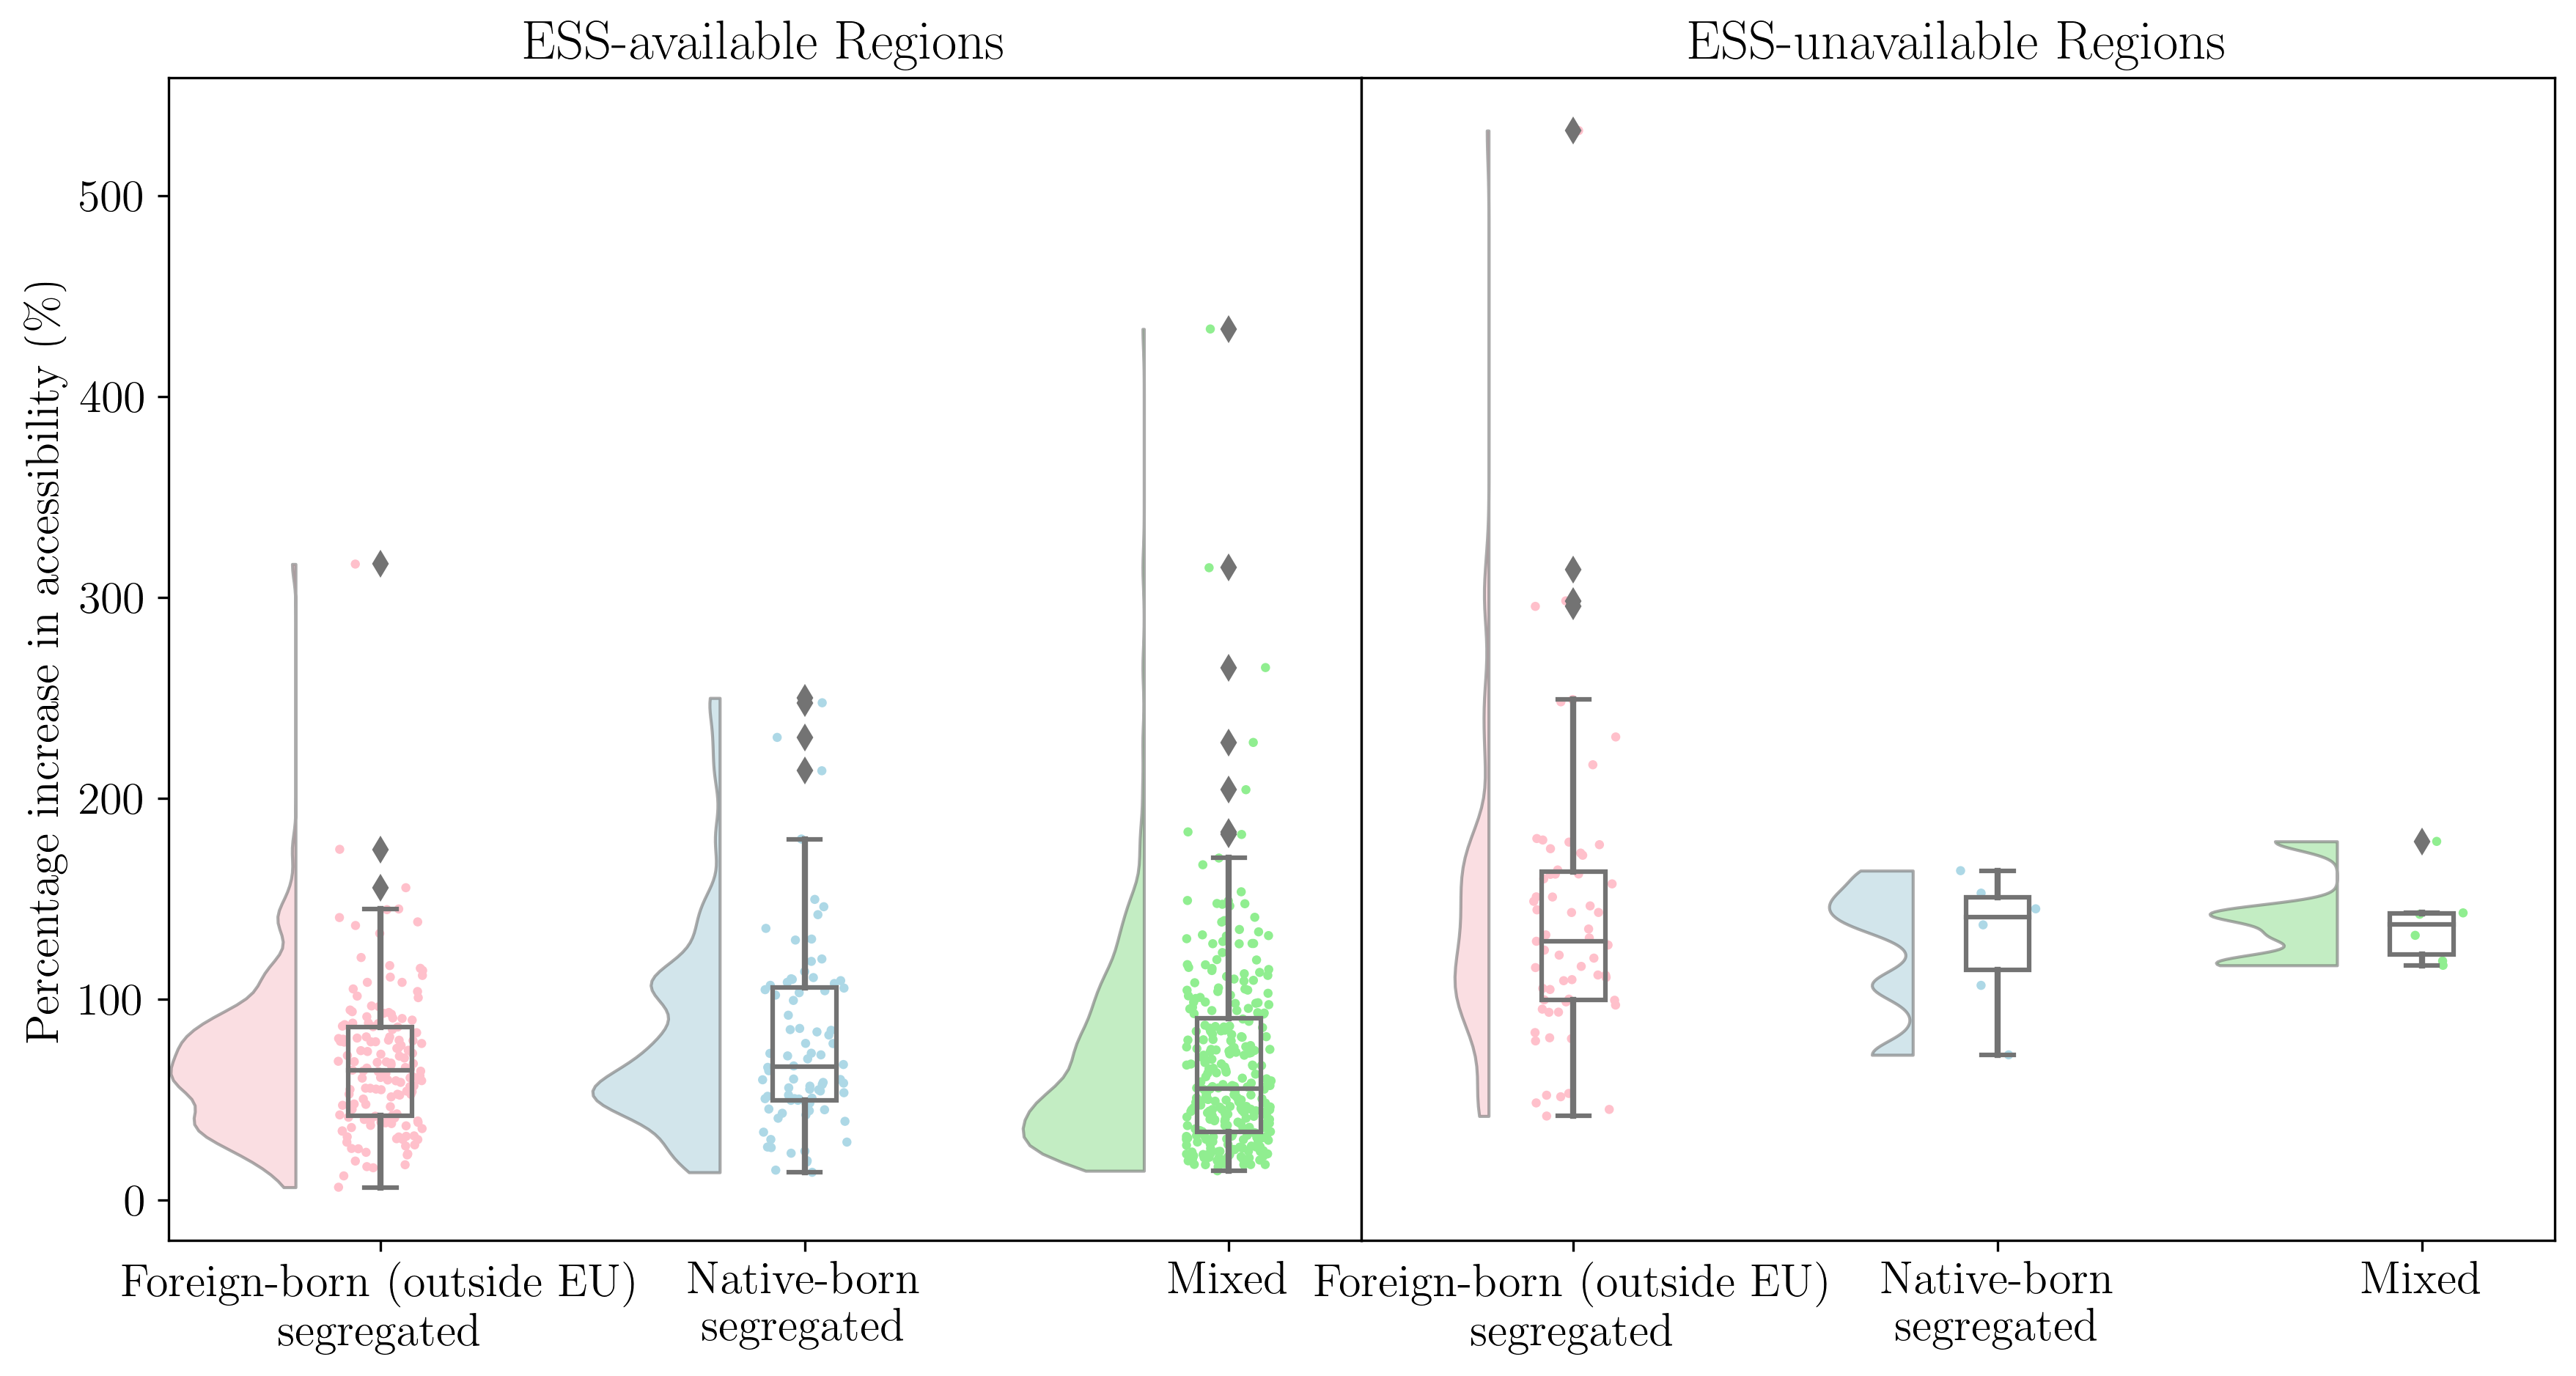

In [25]:
import ptitprince as pt 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns


# rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# rc('text', usetex=True)
# plt.rcParams.update({'font.size': 26})

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{eulervm}',
    'font.family': 'serif',
    'font.serif': 'Computer Modern',
    'font.size': 15,
})

COLORS1 = ["pink", "lightblue", "lightgreen"]



fig, axes = plt.subplots(1, 2, figsize=(14, 7), dpi=300, sharey=True, sharex=False)

# Create Raincloud plot for available_region
ort = "v"
ax1 = pt.RainCloud(x="nativity", y="gain_ratio", data=available_jobs, ax=axes[0], 
                   orient=ort, alpha=0.6, palette=COLORS1, width_viol = .6)
ax1.set(ylabel='', xlabel='')
ax1.set_title('ESS-available Regions')
ax1.set_ylabel(r'Percentage increase in accessibility $(\%)$') 
# ax1.annotate('(a)', xy=(0.5, 0.95), xycoords='axes fraction', fontsize=12,
#              ha='center', va='center')

# Create Raincloud plot for unavailable_region
ax2 = pt.RainCloud(x="nativity", y="gain_ratio", data=unavailable_jobs, ax=axes[1], 
                    orient=ort, alpha=0.6, palette=COLORS1, width_viol = .6)
ax2.set(ylabel='', xlabel='')
ax2.set_title('ESS-unavailable Regions')
ax2.set()
ax2.tick_params(axis='y', length=0)

plt.subplots_adjust(wspace=0)
plt.savefig('result_output/new_nativity.pdf', bbox_inches='tight', dpi=300)
plt.show()

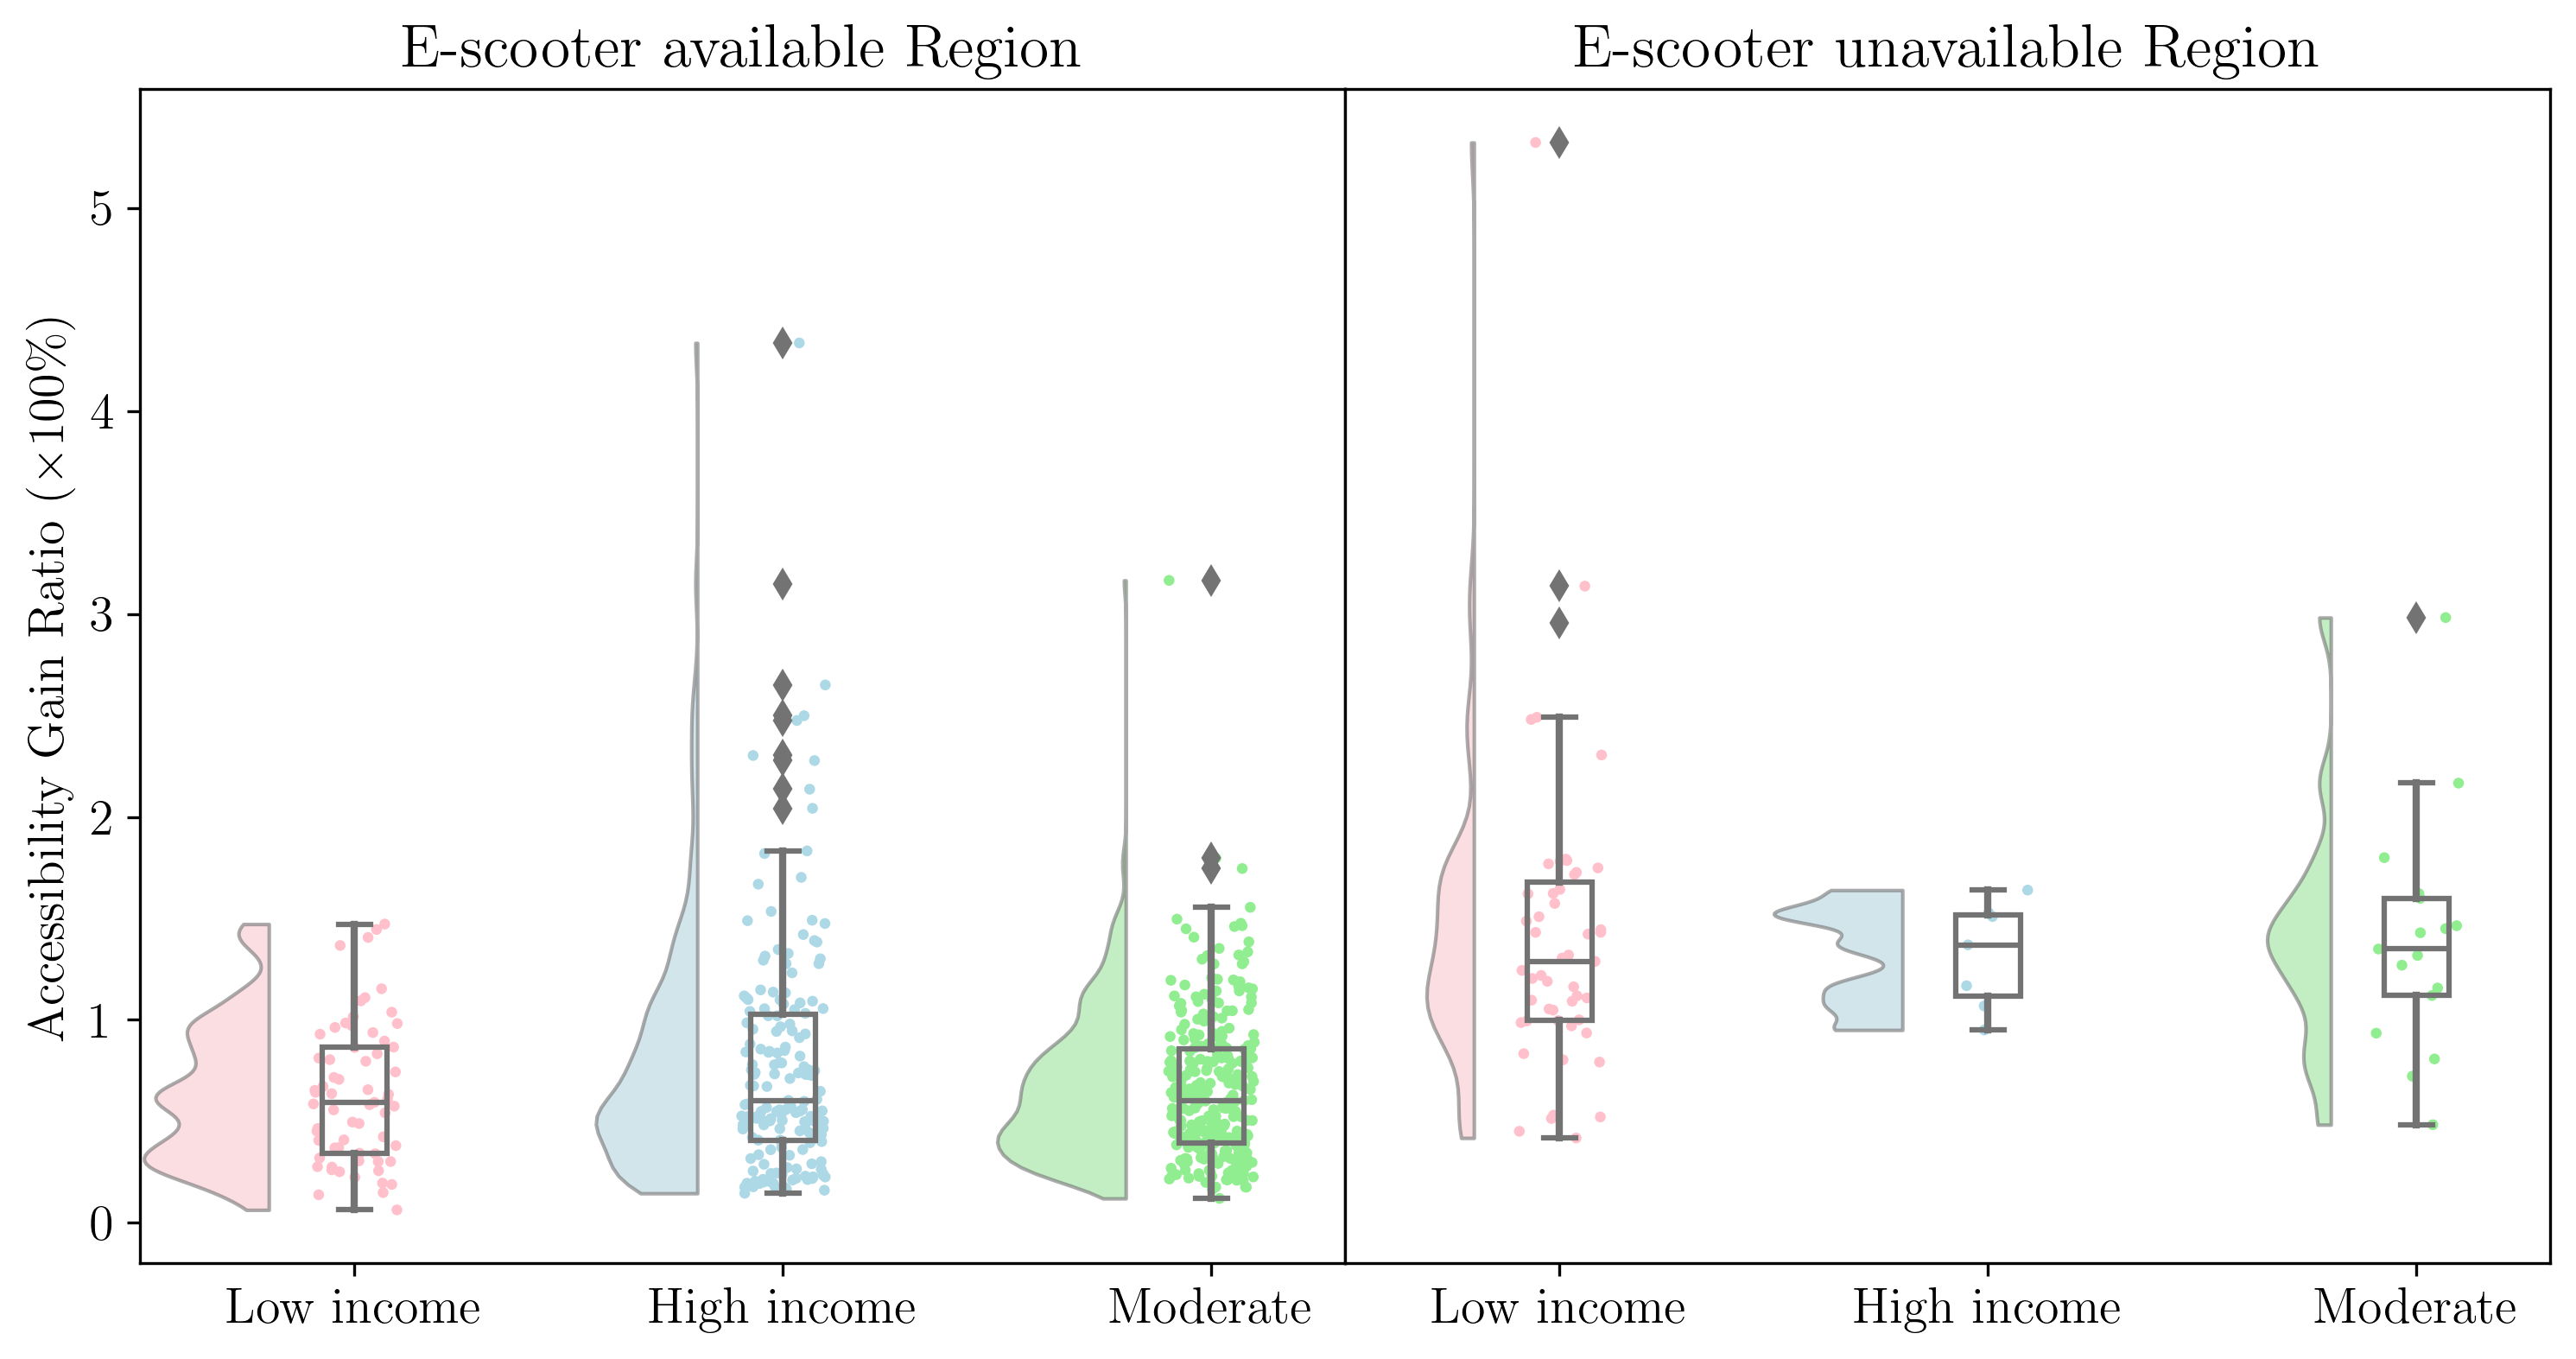

In [10]:
import ptitprince as pt 
import seaborn as sns

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})

COLORS1 = ["pink", "lightblue", "lightgreen"]


fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300, sharey=True, sharex=False)

# Create Raincloud plot for available_region
ort = "v"
ax1 = pt.RainCloud(x="Income", y="gain_ratio", data=available_jobs, ax=axes[0], 
                   orient=ort, alpha=0.6, palette=COLORS1, width_viol = .6)
ax1.set(ylabel='', xlabel='')
ax1.set_title('E-scooter available Region')
ax1.set_ylabel(r'Accessibility Gain Ratio $(\times 100\%)$') 
# ax1.annotate('(a)', xy=(0.5, 0.95), xycoords='axes fraction', fontsize=12,
#              ha='center', va='center')

# Create Raincloud plot for unavailable_region
ax2 = pt.RainCloud(x="Income", y="gain_ratio", data=unavailable_jobs, ax=axes[1], 
                    orient=ort, alpha=0.6, palette=COLORS1, width_viol = .6)
ax2.set(ylabel='', xlabel='')
ax2.set_title('E-scooter unavailable Region')
ax2.set()
ax2.tick_params(axis='y', length=0)
# ax2.set_facecolor((1, 1, 0.8, 0.2))

plt.subplots_adjust(wspace=0)
plt.savefig('result_output/Income.png', bbox_inches='tight', dpi=300)
plt.show()

# Sankey

In [23]:
import plotly.graph_objects as go

NODES = dict(           
    label = ["Foreign-born (outside EU)<br>              segregated",
             "Native-born segregated", 
             "Mixed", 
             "Low income", 
             "High income", 
             "Moderate"],
    color = ["dodgerblue",  
             "seagreen",  
             "orange", 
             "lightseagreen", 
             "greenyellow", 
             "mediumspringgreen"],
)

LINKS = dict(   
    source = [0, 0, 0, 1, 1, 1, 2, 2, 2],
    target = [3, 4, 5, 3, 4, 5, 3, 4, 5],  
    value =  [50, 2, 12, 0, 4, 1, 3, 1, 2], 
    color = ["lightskyblue", "lightskyblue", "lightskyblue",      
             "lightgreen", "lightgreen", "lightgreen",  
             "bisque", "bisque", "bisque"],
)

data = go.Sankey(node=NODES, link=LINKS)
fig = go.Figure(data)

fig.update_layout(
    width=500, height=500,
    margin=dict(
        l=30,
        r=30,
        b=30,
        t=30,
        pad=9
    ),
    font=dict(family='Palatino', size=16),
)

fig.write_image('result_output/sankey_unavail.pdf', scale=10)
fig.show()


In [24]:
import plotly.graph_objects as go

NODES = dict(           
    label = ["Foreign-born (outside EU)<br>              segregated", "Native-born segregated", "Mixed", "Low income", "High income", "Moderate"],
    color = ["dodgerblue",  "seagreen",  "orange", "lightseagreen", "greenyellow", "mediumspringgreen" ])

LINKS = dict(   
  source = [  0,  0,  0,  1,  1,  1,  2,  2,  2],
  target = [  3,  4,  5,  3,  4,  5,  3,  4,  5], 
  value =  [ 40, 25, 87,  7, 45, 32, 18, 100, 178],

  color = [   
  "lightskyblue",   "lightskyblue",   "lightskyblue",      
  "lightgreen", "lightgreen", "lightgreen",  
  "bisque",       "bisque",       "bisque"],)


data = go.Sankey(node = NODES, link = LINKS)
fig = go.Figure(data)

fig.update_layout(
    width=500, height=500,
    margin=dict(
        l=30,
        r=30,
        b=30,
        t=30,
        pad=9
    ),
    font = dict(family='Palatino', size=16),)
#     title="Escooter-unavailable Region",  font_size=16)
fig.write_image('result_output/sankey_avail.pdf', scale=10)
fig.show()